# Solutions - Homework 3

## Markets Foundations

### UChicago Financial Mathematics

#### September 2023

* Mark Hendricks
* hendricks@uchicago.edu

#### This assignment is not submitted, graded, or for credit. 
Rather, it is assigned for learning purposes.

$\newcommand{\rUSD}{r^{\text{US}}}$
$\newcommand{\rGBP}{r^{\text{GBP}}}$
$\newcommand{\rxGBP}{\widetilde{r}^{\text{GBP}}}$

# 1 TIPS and Inflation

Use the data in `data/inflation_expectation_data.xlsx`

## 1.1

Use the **yields** for the 5-year nominal note and the 5-year TIPS to construct an index of expected 5-year inflation.

* Plot the expected inflation over time
* Report the minimum and maximum inflation expectations, and the dates on which they occured.

## 1.2

Use the data on **consumer prices** to construct year-over-year inflation.

That is, measure inflation as the percentage change in CPI over 12 months, reported on a monthly basis.

Plot CPI, and report its minimum and maximum values, along with the dates on which they occured.

## 1.3

Calculate two monthly change series:
1. Go back to the raw CPI data, and calculate its month-over-month percentage change. Denote this as $z^1_t$.

2. Aggregate the inflation expectation series calculated above into a monthly series. Furthermore, take its month-over-month difference. Denote this as $z^2_t$. Consider using 
    * .resample('M').last()diff()

### (a)
Report the correlation between these two series, 

$$\text{corr}(z^1_t,z^2_t)$$

### (b)
Does a change in CPI predict a futre change in the 5-year inflation expectation? Or vice-versa? Check by calculating the following two correlations:

$$\text{corr}(z^1_t,z^2_{t+1})$$

$$\text{corr}(z^1_{t+1},z^2_t)$$

What do you conclude?

# <span style="color:red">Solution 1</span>

In [1]:
import pandas as pd
import numpy as np
import datetime
import warnings

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)
import sys
sys.path.insert(0, '../cmds')
from treasury_cmds import *

## <span style="color:red">1.1</span>

In [2]:
pd.read_excel('../data/inflation_expectation_data.xlsx',sheet_name='descriptions').set_index('Label')

,Description
Label,
Note (5yr),Market Yield on U.S. Treasury Securities at 5-...
TIPS (5yr),Market Yield on U.S. Treasury Securities at 5-...
CPI,Consumer Price Index for All Urban Consumers: ...


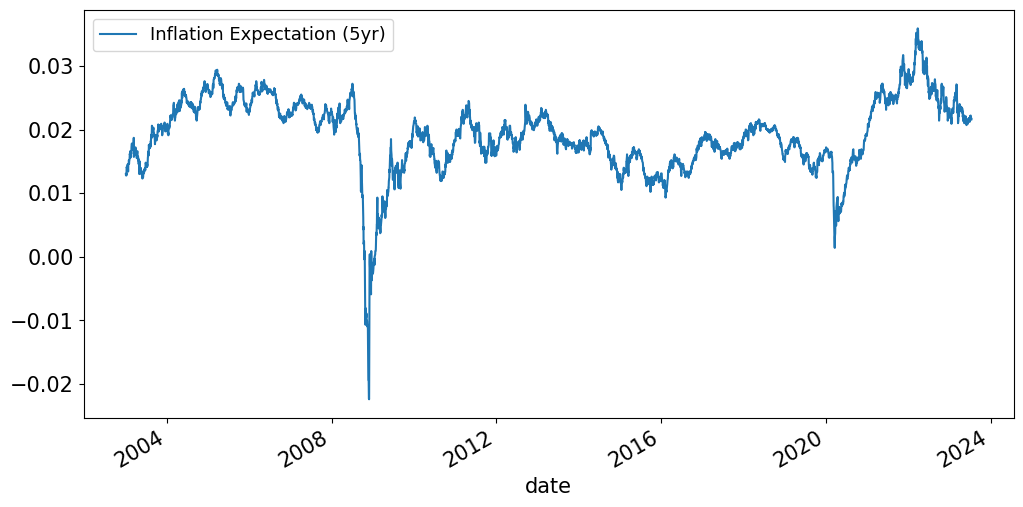

In [3]:
yields = pd.read_excel('../data/inflation_expectation_data.xlsx',sheet_name='yields').set_index('date')
Einfl = -yields.diff(axis=1).iloc[:,[1]]
Einfl.columns=['Inflation Expectation (5yr)']
Einfl.plot();

In [4]:
expectation_extremes = pd.concat([pd.concat([Einfl.idxmin(),Einfl.min()],axis=1),pd.concat([Einfl.idxmax(),Einfl.max()],axis=1)],axis=0).rename(columns={0:'date',1:'Exp.Infl'})
expectation_extremes.index = ['min','max']
expectation_extremes.style.format({'date':'{:%Y-%m-%d}','Exp.Infl':'{:.2%}'})

,date,Exp.Infl
min,2008-11-28,-2.24%
max,2022-03-25,3.59%


## <span style="color:red">1.2</span>

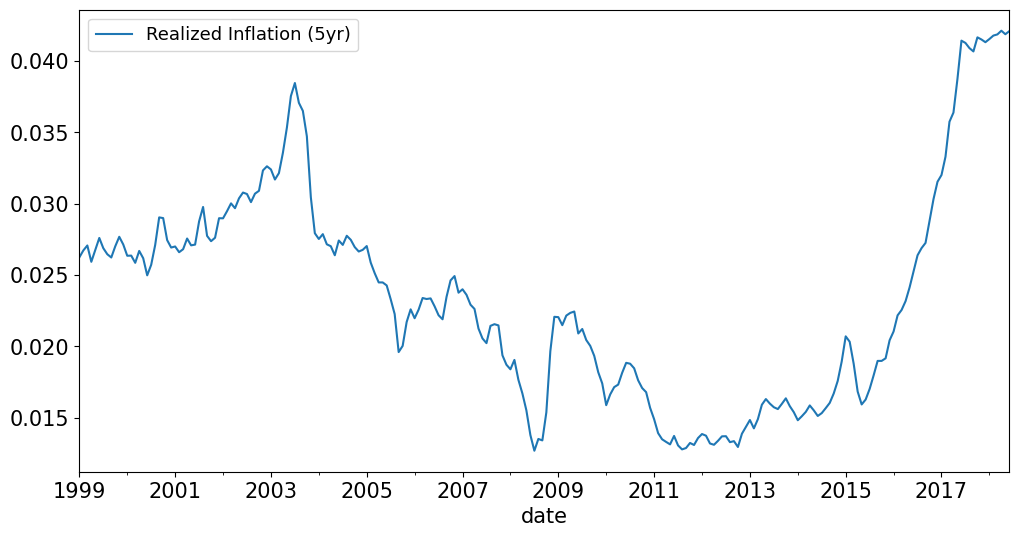

In [5]:
FREQ = 12
YRS = 5

cpi = pd.read_excel('../data/inflation_expectation_data.xlsx',sheet_name='consumer prices').set_index('date')
inflation = ((cpi.shift(-FREQ*YRS)/cpi - 1)/YRS).dropna().rename(columns={'CPI':f'Realized Inflation ({YRS}yr)'})

inflation.plot();

In [6]:
extremes_inflation = pd.concat([pd.concat([inflation.idxmin(),inflation.min()],axis=1),pd.concat([inflation.idxmax(),inflation.max()],axis=1)],axis=0).rename(columns={0:'date',1:'Inflation'})
extremes_inflation.index = ['min','max']
extremes_inflation.style.format({'date':'{:%Y-%m-%d}','Inflation':'{:.2%}'})

,date,Inflation
min,2008-07-31,1.27%
max,2018-04-30,4.21%


## <span style="color:red">1.3</span>
### <span style="color:red">(a)</span>

In [7]:
cpi = pd.read_excel('../data/inflation_expectation_data.xlsx',sheet_name='consumer prices').set_index('date')
cpi_change = cpi.pct_change()
expectation_change = Einfl.resample('M').last().diff()

comparison = cpi_change.join(expectation_change,how='inner').dropna()
comparison.corr().iloc[[0],[1]].style.format('{:.1%}')

,Inflation Expectation (5yr)
CPI,27.7%


### <span style="color:red">(b)</span>

In [8]:
comparison = cpi_change.join(expectation_change.shift(),how='inner').dropna()
comparison.corr().iloc[[0],[1]].style.format('{:.1%}')

,Inflation Expectation (5yr)
CPI,49.5%


In [9]:
comparison = cpi_change.shift().join(expectation_change,how='inner').dropna()
comparison.corr().iloc[[0],[1]].style.format('{:.1%}')

,Inflation Expectation (5yr)
CPI,-11.2%


## <span style="color:red">Extra</span>

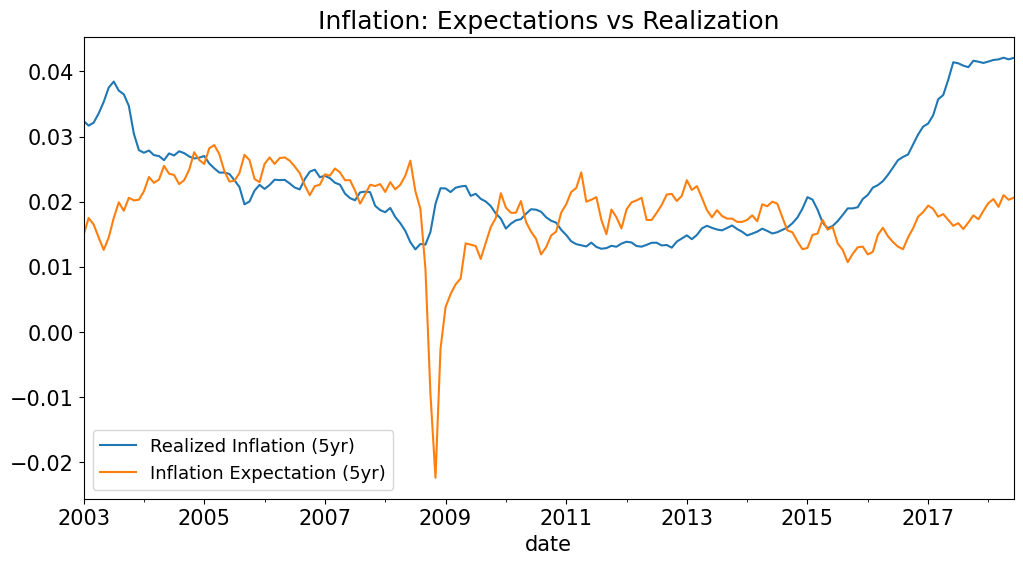

In [10]:
FREQ = 12
YRS = 5

cpi = pd.read_excel('../data/inflation_expectation_data.xlsx',sheet_name='consumer prices').set_index('date')
inflation = ((cpi.shift(-FREQ*YRS)/cpi - 1)/YRS).dropna().rename(columns={'CPI':f'Realized Inflation ({YRS}yr)'})
Einfl_monthly = Einfl.resample('M').last()

comparison = inflation.join(Einfl_monthly,how='inner')

comparison.plot(title='Inflation: Expectations vs Realization');

***

# 2 Currency and Carry

The problem is based on data in `data/fx_data.xlsx`.

Use the `USUK` column of the tab, `fx rates`, which gives the **direct** exchange rate between the pound (sterling) and USD. (Being a direct quote means the exchange rates are listed as dollars per foreign currency.)

Combine this with the overnight interest rates given in the `interest rates` tab. Note that `SONIA` is the British overnight rate.

Both SOFR and SONIA are quoted as annualized rates. As is typical with money-market rates, they are scaled by 360 to annualize. Thus, in the calculations below, be careful to divide them by 360.

## 2.1

Using all these, calculate the time-series of returns to investing in the pound (from a US perspective.)

Denote this as $\rGBP$.

* Plot the cumulative return series for $\rGBP$. That is, if the time-series of daily returns is `retsGBP`, then plot `(1+retsGBP).cumprod().plot()`.

* For comparison, plot the cumulative return of just investing in the US overnight rate, SOFR.


## 2.2
Report the mean of the excess return,

$$\rxGBP \equiv \rGBP - \rUSD$$

which is the return of investing in pounds sterling minus the US SOFR rate. This is giving the excess return earned in the instance that the investor is borrowing with SOFR and investing it in pounds sterling.

* Annualize the mean excess return, (by multiplying by 360.)

Would this carry trade have been profitable over this period?

## 2.3
Was the interest rate differential positive or negative, (on average,) over this time?

If the carry trade was not profitable, describe step-by-step how one could take the opposite (short) side of this carry trade.

## EXTRA 2.4

Calculate the profit of shorting GBP on notional of £1mm GBP. 
* Assume that the notional is rebalanced every day to simplify the calculation. This allows you to simply calculate the excess return timeseries and multiply it by the notional.

# <span style="color:red">Solution 2</span>

## <span style="color:red">2.1</span>

In [11]:
LOADFILE = '../data/fx_data.xlsx'
fx = pd.read_excel(LOADFILE,sheet_name='fx rates').set_index('DATE')
rates = pd.read_excel(LOADFILE,sheet_name='interest rates').set_index('DATE')

In [12]:
FREQ = 360

rets = pd.DataFrame(dtype=float,index=rates.index)
rets['GBP'] = fx['USUK']/fx['USUK'].shift() * (1+rates['SONIA']/FREQ)  - 1
rets['USD'] = rates['SOFR']/FREQ

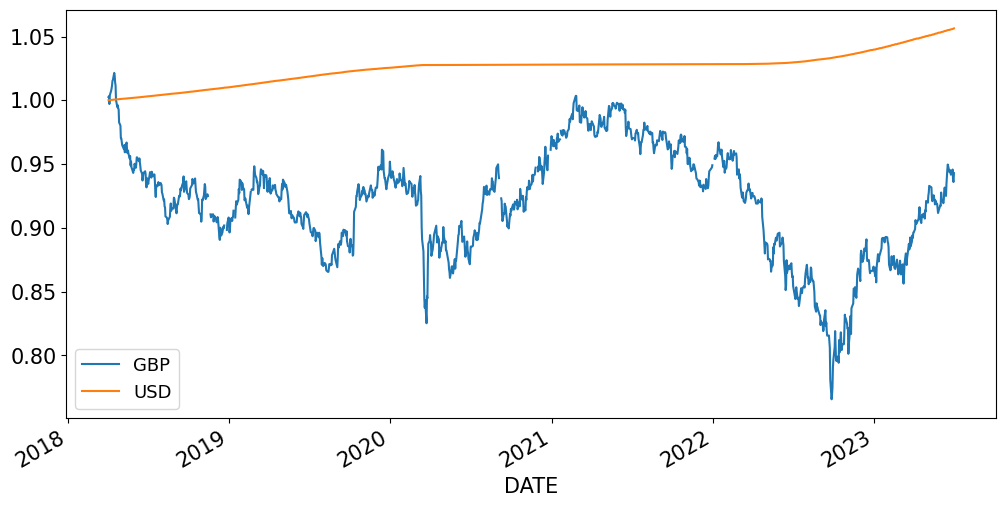

In [13]:
(rets+1).cumprod().plot();

## <span style="color:red">2.2</span>

The excess return of GBP is negative over this time.

In [14]:
rx = rets['GBP'] - rets['USD']
print(f'Mean excess return of carrying GBP is {rx.mean() * FREQ:.2%}')

Mean excess return of carrying GBP is -2.55%


## <span style="color:red">2.3</span>

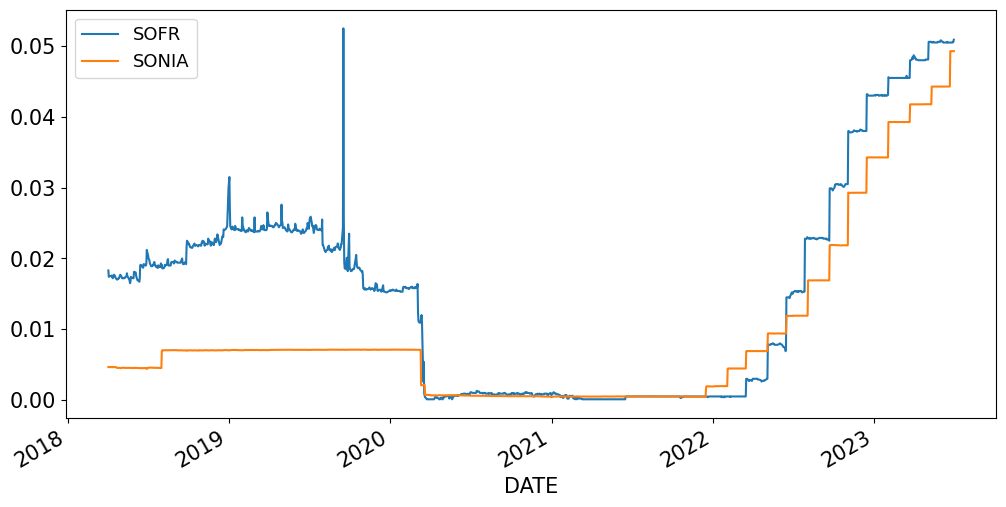

In [15]:
rates.plot();

In [16]:
rates.mean().to_frame().style.format('{:.2%}')

,0
SOFR,1.54%
SONIA,0.91%


The USD interest rate was higher on average, so the proper **carry** trade would have been to be long USD and short GBP.

This would work as follows:
1. At $T_1$
    * Borrow GBP at the SONIA rate
    * Sell the (borrowed) GBP for USD at the spot exchange rate
    * Invest the USD at the SOFR rate

2. At $T_2$
    * Take the USD (including SOFR return),
    * Buy GBP at the spot exchange rate sufficient to close out the short position

This will have an excess return (in terms of GBP) of

$$\frac{S_{t}}{S_{t+1}}R_{t,t+1}^{\$} - R^*_{t,t+1}$$

or in terms of USD, this excess return is

$$S_{t}R_{t,t+1}^{\$} - S_{t+1}R^*_{t,t+1}$$

In [17]:
rx_short = pd.DataFrame(dtype=float,index=rates.index)
rx_short['GBP'] = fx['USUK'].shift() * (1+rates['SOFR']/FREQ)  - fx['USUK'] * (1+rates['SONIA']/FREQ)
rx_short.rename(columns={'GBP':'Short GBP'},inplace=True)

perf = pd.DataFrame(index=['Long GBP','Short GBP'],dtype=float,columns=['average (annualized) excess return (USD)'])
perf.loc['Long GBP'] = rx.mean() * FREQ
perf.loc['Short GBP'] = rx_short.mean()[0] * FREQ
perf.style.format('{:.1%}')

,average (annualized) excess return (USD)
Long GBP,-2.5%
Short GBP,4.3%


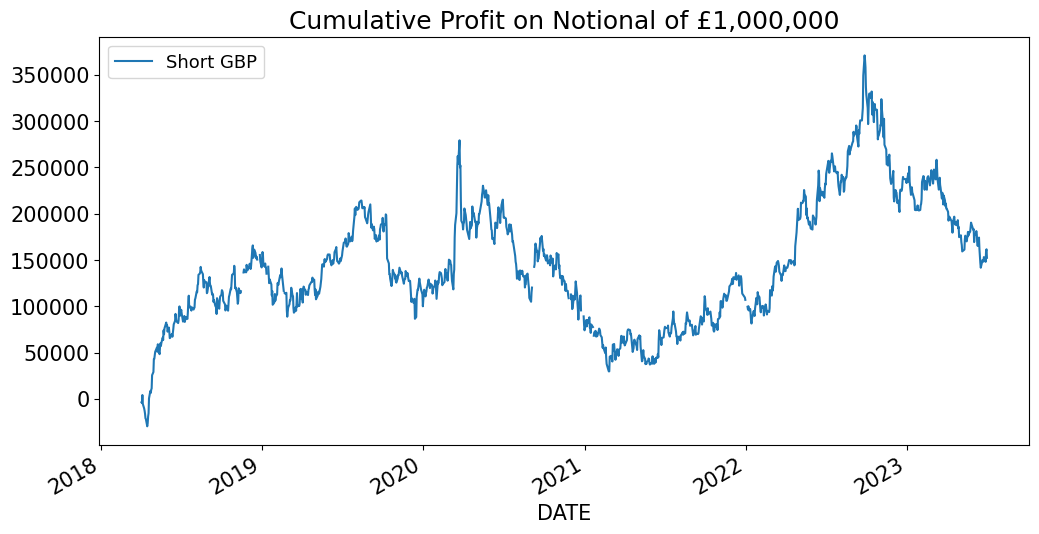

In [18]:
NOTIONAL_GBP = 1e6
(NOTIONAL_GBP * rx_short).cumsum().plot(title=f'Cumulative Profit on Notional of £{NOTIONAL_GBP:,.0f}');